## Pobieranie notowań

In [1]:
from pytickersymbols import PyTickerSymbols
from dataclasses import dataclass, field
import pandas as pd
import datetime as dt
import pandas_datareader as pdr
from concurrent.futures import ThreadPoolExecutor as Executor  # przyspieszymy ściąganie, kolejność nie gra dla nas roli

*pytickersymbols* - biblioteka umożliwiająca łatwe pobieranie m.in składów indeksów giełdowych


dokumentacja: https://pypi.org/project/pytickersymbols/


instalacja:

```bash
pip install pytickersymbols
```


In [2]:
@dataclass
class Scraper:
    """Zadaniem tego obiektu jest pobieranie notowań spółek z określonego zestawu za zadany okres czasu
    oraz zapisywanie ich do formatu pandasowej ramki danych"""
    start: dt.date
    end: dt.date
    all_dfs: list = field(default_factory=list)
    data = pd.DataFrame()
    tickers: list = field(default_factory=list)
        
    @property
    def details(self):
        return f"Scraper(tickers_loaded: {len(self.tickers)}, data columns loaded: {len(self.all_dfs)})"

    def pull_tickers(self, index="Dow Jones"):
        """Funkcja ściąga aktualny skład wskazanego indeksu i zapisuje do listy tickerów. Dostępne opcje to 'Dow Jones',
        'S&P 500' oraz 'DAX'."""
        stock_data = PyTickerSymbols()
        
        if index == "Dow Jones":
            tickers = stock_data.get_dow_jones_nyc_yahoo_tickers()
            
        elif index == "S&P 500":
            tickers = stock_data.get_sp_500_nyc_yahoo_tickers()
            
        elif index == "DAX":
            tickers = stock_data.get_dax_frankfurt_yahoo_tickers()
            
        else:
            raise ValueError(f"Brak wsparcia dla indeksu {index}. Możliwe opcje: 'Dow Jones', 'S&P 500', 'DAX'")
            
        self.tickers += list(tickers)
        
    def set_tickers(self, tickers):
        """Obiekt dopuszcza podanie customowego zestawu tickerów do analizy"""
        self.tickers = tickers        

    def get_time_series(self, ticker, provider="yahoo"):
        """Dla danego tickera funkcja pobierze notowania na zadany w konstruktorze okres czasu"""
        df = pdr.DataReader(ticker, provider, self.start, self.end)["Adj Close"]  # bierzemy tylko kolumnę Adjusted Close
        df = df.rename(ticker)
        self.all_dfs.append(df)  # obiekty zbieramy do listy, która posłuży potem do utworzenia jednej tabeli zbiorczej

    def scrape_data(self):
        with Executor(max_workers=30) as executor:  # używamy concurrent computingu żeby przyspieszyć ściąganie danych
            executor.map(self.get_time_series, self.tickers)
        self.data = self.merge_data_frames(self.all_dfs)
        self.data = self.data.sort_index(axis=1)  # sortujemy nazwy kolumn alfabetycznie (trafiają w losowym porządku)

    @staticmethod
    def merge_data_frames(dfs) -> pd.DataFrame:
        df = pd.concat(dfs, axis=1)  # funkcja pandas.concat bierze listę obiektów typu DataFrame i tworzy jedną ramkę danych
        return df

In [3]:
end = dt.date.today()  # aktualna data
start = end - dt.timedelta(days=365*2)  # cofamy się o dwa lata
scraper = Scraper(start, end)
scraper.pull_tickers()
scraper.scrape_data()
df = scraper.data  # zapisujemy efekty pracy Scrapera do obiektu df: pandas.DataFrame

In [4]:
scraper.details

'Scraper(tickers_loaded: 31, data columns loaded: 31)'

In [5]:
df.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-18,65.797630,208.290787,116.206589,367.274811,136.538559,162.770004,42.406425,107.837418,146.770660,48.830181,...,75.275909,147.296112,92.519699,116.033600,127.772377,264.634247,177.470734,54.479897,57.137848,116.370926
2019-11-19,65.598099,211.905945,116.536766,364.829376,136.148727,163.960007,42.706982,105.927177,147.496323,47.994171,...,75.741180,147.345108,91.959747,115.586182,128.885605,265.894745,180.542847,54.534889,56.685841,116.022552
2019-11-20,64.834442,212.859283,115.856987,368.716248,134.570221,164.199997,42.340683,106.736755,146.054947,47.346931,...,76.295914,147.089493,91.409622,116.414375,128.857040,267.184357,179.446365,54.516560,56.584373,115.287071
2019-11-21,64.543762,215.039703,115.371391,364.272675,136.319855,162.880005,42.115265,108.037537,146.025116,48.434650,...,76.465919,146.951859,90.535301,114.558075,128.152954,268.144226,177.697937,54.635712,55.920197,115.993530
2019-11-22,64.487106,217.795898,115.623894,369.143707,136.814346,162.809998,42.124653,107.910187,147.406845,48.722305,...,76.456978,147.060013,91.694496,114.510475,128.571594,268.425354,177.283066,54.764030,55.901741,115.509651


## Badanie korelacji dziennych zwrotów spółek

In [6]:
df_ret = df.pct_change()  # metoda pct_change klasy pandas.DataFrame tworzy ramkę danych z "dziennymi" zmianami kursów

Dokumentacja metody pct_change: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html

In [7]:
corr_matrix = df_ret.corr()  # tworzymy macierz korelacji

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

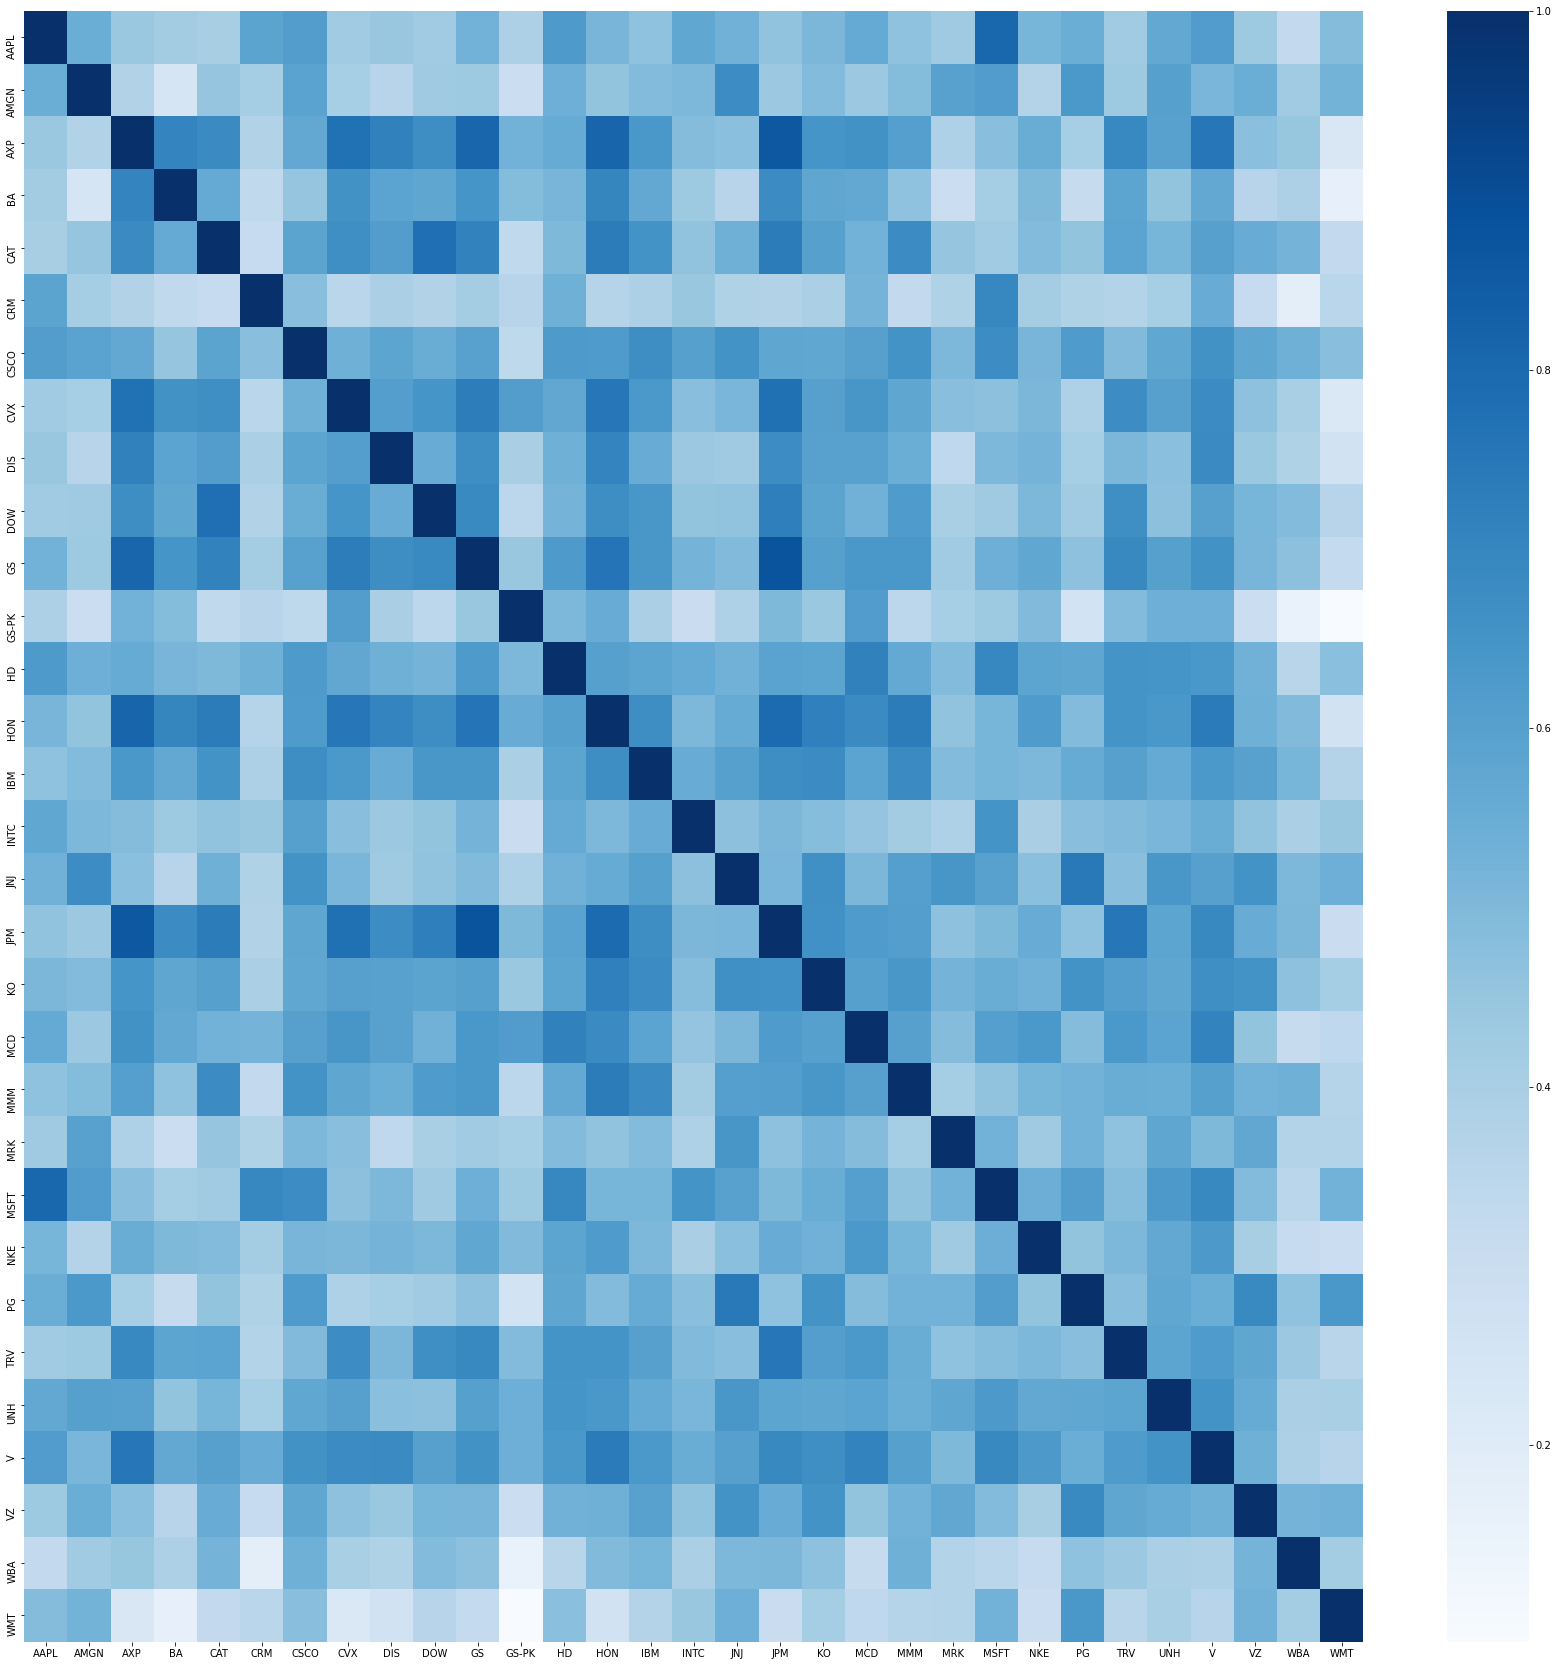

In [9]:
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, cmap="Blues", annot=False)
plt.show()

## Układ korelacji jako problem z teorii grafów

In [10]:
import networkx as nx  # biblioteka do pracy z grafami

In [11]:
def produce_graph(assets, corr_threshold):
    nodes = []
    for i in assets:
        for j in assets:
            if i == j:
                continue
            corr = corr_matrix.loc[i, j]
            if corr >= corr_threshold:
                pair = (i, j)
                nodes.append(pair)
                
    graph = nx.Graph()
    graph.add_edges_from(nodes)
    return graph, corr_threshold

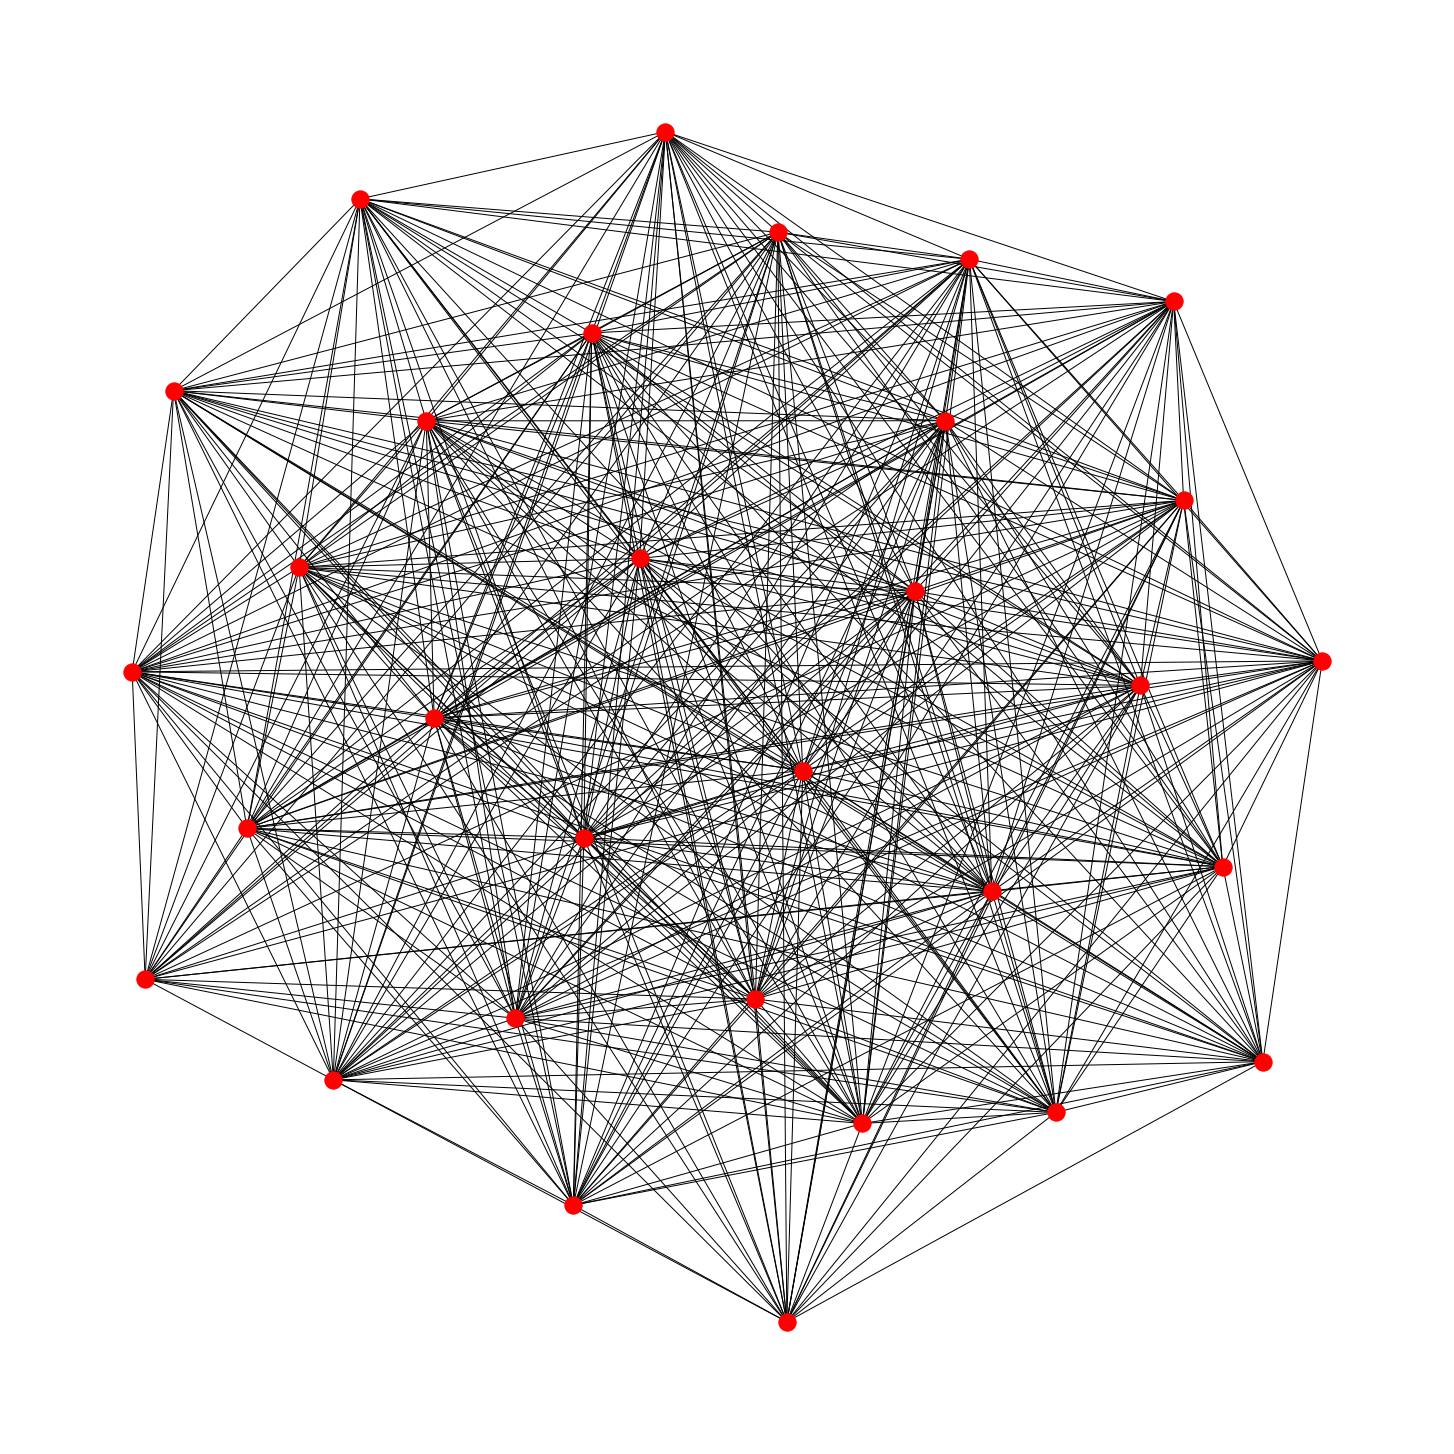

In [12]:
assets = df.columns

G, corr_threshold = produce_graph(assets, corr_threshold=0.3)

plt.figure(figsize=(20, 20))
nx.draw(G, node_color="r")
plt.show()

In [13]:
others = list(set(assets) - set(G.nodes))
others

[]

## Wybór spółek do zdywersyfikowanego portfela

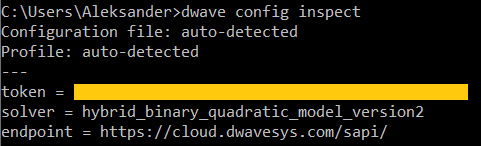

Listę dostępnych solverów można otrzymać wykonując:
```python
from dwave.cloud import Client
client = Client.from_config(token=my_secret_token)
client.get_solvers()   
```

Do celów niniejszej analizy użyto solvera *hybrid_binary_quadratic_model_version2*.

In [14]:
import dwave_networkx as dnx
from dwave.system import LeapHybridSampler  # hybrydowy sampler

In [15]:
my_sampler = LeapHybridSampler()
algo_chosen = dnx.maximum_independent_set(G, sampler=my_sampler, label="QPD-2.0")

In [16]:
algo_chosen

['CRM', 'WBA']

## Wizualizacja wyników

In [17]:
"""Kolorujemy nasz wyjściowy graf - wybrane przez algorytm spółki będą niebieskie, reszta pozostanie na czerwono"""
color_map = []
for node in G:
    if node in algo_chosen:
        color_map.append("blue")
    else:
        color_map.append('red')

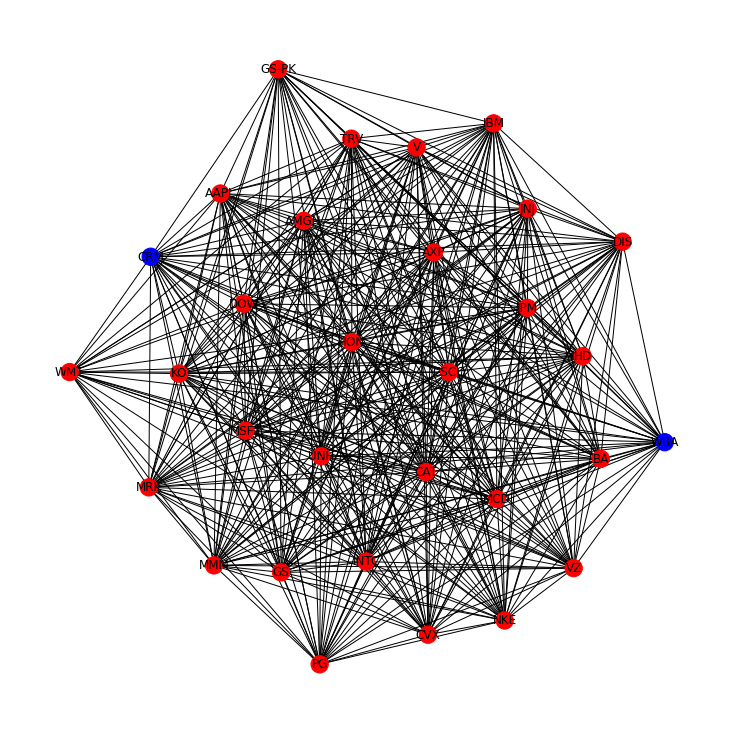

In [18]:
plt.figure(figsize=(10, 10))
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

In [19]:
dnx.is_independent_set(G, algo_chosen)

True

## Ostateczny wynik

In [22]:
chosen_tickers = algo_chosen + others  # portfel po uwzględnieniu spółek, które nie znalazły się w grafie
chosen_tickers

['CRM', 'WBA']

In [23]:
corr_matrix.loc['CRM', 'WBA']

0.18437134309002015

In [21]:
import json

# zapis rezultatów do formatu json
data = {
    "correlation_threshold": corr_threshold,
    "tickers": chosen_tickers
}

with open('tickers.json', 'w') as fp:
    json.dump(data, fp)
    
df.loc[:, chosen_tickers].to_csv("data.csv", sep=",")

## Co dalej...

- Mamy spółki, ale nie znamy proporcji
- Symulacja portfeli w poszukiwaniu najwyższego Sharpe Ratio (albo optymalizacja?)
- Po paru miesiącach możemy zweryfikować, na ile opłacalna była wskazana przez program inwestycja
- Możemy też porównać ten wynik z wynikiem jaki otrzymalibyśmy stosując klasyczne procedury
- Dow Jones to mały indeks - może warto wypróbować większy? (np. S&P 500)